In [414]:
import numpy as np
import os
from scipy import stats
import scipy.integrate as integrate
import tensorflow as tf
from utils.training import *

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

from utils.training import *

np.random.seed(666)
eps = 1e-7

In [415]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [416]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

In [417]:
# Empiric estimation of losses

N = 5 * 10**5
X = np.concatenate((bkgd.rvs(size = N), sgnl.rvs(size = N)))
y = np.concatenate((np.zeros(N), np.ones(N)))

def bce(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b)
    return 2 * -np.mean((yy) * np.log(y_hat + eps) + (1 - yy) * np.log(1 - y_hat + eps), axis = 0)

def mse(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b)
    return 2 * -np.mean((yy) * -(1 - y_hat)**2 + (1 - yy) * -(y_hat)**2, axis = 0)

def mse_p(a, b, p):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = sig(a*XX + b) 
    return 2 * -np.mean((yy) * -(1 - y_hat)**p + (1 - yy) * -(y_hat)**p, axis = 0)

def mlc(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * np.log(y_hat + eps) + (1 - yy) * (1 - y_hat), axis = 0)

def exp_mlc(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * y_hat + (1 - yy) * (1 - np.exp(y_hat)), axis = 0)

def sqr(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / (y_hat + eps)**0.5) + (1 - yy) * -(y_hat)**0.5, axis = 0)

def exp_sqr(a, b):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / np.exp(y_hat)**0.5) + (1 - yy) * -(np.exp(y_hat))**0.5, axis = 0)

def sqr_r(a, b, r):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = relu(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / (y_hat + eps)**(r/2)) + (1 - yy) * -(y_hat)**(r/2), axis = 0) 

def exp_sqr_r(a, b, r):
    XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
    yy = np.repeat(y, np.prod(np.shape(a))).reshape(y.shape + np.shape(a))
    y_hat = np.exp(a*XX + b)
    return 2 * -np.mean((yy) * -(1 / (y_hat + eps)**(r/2)) + (1 - yy) * -(y_hat)**(r/2), axis = 0) 

@np.vectorize
def mse_error(a, b, p):
    y_hat = sig(a*X + b)
    lik = (y_hat / (1 - y_hat))**(p - 1)
    return np.abs(lik - lr(X)).mean(axis = 0)

@np.vectorize
def sqr_error(a, b, r):
    y_hat = np.exp(a*X + b)
    lik = (y_hat)**r
    return np.abs(lik - lr(X)).mean(axis = 0)

In [418]:
# Numerical estimation of losses

def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nmse_p(a, b, p):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**p + \
                    bkgd.pdf(x) * -(sig(a*x + b)**p) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nsqr_r(a, b, r):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**(r/2) + \
                    bkgd.pdf(x) * -relu(a*x + b)**(r/2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def nexp_sqr_r(a, b, r):
    g = lambda x: -(sgnl.pdf(x) * -1 / (np.exp(a*x + b))**(r/2) + \
                    bkgd.pdf(x) * -np.exp(a*x + b)**(r/2) )
    #print(g(np.linspace(-1, 1, 1001)))
    return integrate.quad_vec(g, -100, 100)[0]
    #return integrate.quad_vec(g, -np.inf, np.inf)[0]
    
@np.vectorize
def nmse_error(a, b, p):
    g = lambda x: np.abs(np.exp((p - 1) * (a*x + b)) - np.exp(0.2*x)) * (1/2) * (bkgd.pdf(x) + sgnl.pdf(x))
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nsqr_error(a, b, r):
    g = lambda x: np.abs(np.exp(r * (a*x + b)) - np.exp(0.2*x)) * (1/2) * (bkgd.pdf(x) + sgnl.pdf(x))
    return integrate.quad(g, -np.inf, np.inf)[0]

In [419]:
def gridded(loss, g_min, g_max, f, n_splits):
    chunks = [None] * n_splits
    span = (g_max - g_min) / n_splits
    n_points = int( span / f)
    n_total = int( (g_max - g_min) / f )

    for i in range(n_splits - 1):
        chunks[i] = np.linspace(g_min + i * span, g_min + (i + 1) * span - f, n_points)
    chunks[n_splits - 1] = np.linspace(g_min + (n_splits - 1) * span, g_min + n_splits * span, n_points + 1)
    
    aa, bb = np.meshgrid(np.linspace(g_min, g_max, n_total + 1), np.linspace(g_min, g_max, n_total + 1))
    
    grids = [None] * n_splits**2
    for i in range(n_splits):
        for j in range(n_splits):
            grids[n_splits*i + j] = np.meshgrid(chunks[i], chunks[j])

    losses = [None] * n_splits**2
    for i in range(n_splits**2):
        if i % n_splits == 0 and i > 0: print()
        print(i, end = '\t')
        losses[i] = loss(grids[i][0], grids[i][1])
    losses = np.hstack([np.vstack([losses[j] for j in range(i, i + n_splits)]) for i in range(0, n_splits**2, n_splits)])
    return losses, aa, bb

In [420]:
aa, bb = np.meshgrid(np.linspace(-1, 1, 11), np.linspace(-1, 1, 11))

In [ ]:
zz = nmse_error(aa, bb, 1.05)

In [ ]:
zz = mse_error(aa, bb, 1.05)

In [269]:
a = [4, 4.01]
b = [0, 0]
p = 1.05

In [241]:
cfr = lambda x: sig(a*x + b)
lik = lambda x: (cfr(x) / (1 - cfr(x)))**(p - 1)

In [270]:
XX = np.repeat(X, np.prod(np.shape(a))).reshape(X.shape + np.shape(a))
y_hat = sig(a*XX + b)

In [271]:
y_hat

array([[0.34760044, 0.34724358],
       [0.10021814, 0.09972444],
       [0.9413622 , 0.94174411],
       ...,
       [0.99305186, 0.99313694],
       [0.90964086, 0.91011426],
       [0.21803658, 0.2174927 ]])

In [272]:
(y_hat / (1 - y_hat))**(p-1)

array([[0.96901016, 0.96893391],
       [0.89606694, 0.89582114],
       [1.14889134, 1.14929006],
       ...,
       [1.28160792, 1.28240313],
       [1.12239286, 1.12271689],
       [0.9381389 , 0.93798915]])

In [222]:
lik(XX)

array([0.96901016, 0.89606694, 1.14889134, ..., 1.28160792, 1.12239286,
       0.9381389 ])

In [273]:
mlr = (y_hat / (1 - y_hat))**(1.05 - 1)

In [274]:
mlr

array([[0.96901016, 0.96893391],
       [0.89606694, 0.89582114],
       [1.14889134, 1.14929006],
       ...,
       [1.28160792, 1.28240313],
       [1.12239286, 1.12271689],
       [0.9381389 , 0.93798915]])

In [275]:
lr = make_lr(bkgd, sgnl)

In [276]:
lr(XX)

array([[0.96901016, 0.96901016],
       [0.89606694, 0.89606694],
       [1.14889134, 1.14889134],
       ...,
       [1.28160792, 1.28160792],
       [1.12239286, 1.12239286],
       [0.9381389 , 0.9381389 ]])

In [279]:
np.abs(mlr - lr(XX)).mean(axis = 0)

array([8.13699441e-15, 4.15064260e-04])

In [180]:
1 - y_hat

array([0.33215006, 0.41235108, 0.25965613, ..., 0.88713946, 0.47716369,
       0.27768089])

In [ ]:
# Compute loss using the MAE at each point instead.
def mse_error(a, b, p):
    cfr = lambda x: sig(a*x + b)
    lik = lambda x: (cfr(x) / (1 - cfr(x)))**(p - 1)
    return mae(lik)

### Timing

In [167]:
%%time
for a in np.linspace(-1, 1, 10001):
    mse_error(a, a, 1.05)

CPU times: user 2min 40s, sys: 0 ns, total: 2min 40s
Wall time: 2min 40s


In [168]:
ns = [51, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 2001, 10001]
ts = [.806, 1.64, 3.19, 4.9, 6.42, 7.97, 9.67, 11.2, 12.8, 14.4, 16.2, 17.7, 32.2, 2*60 + 40]

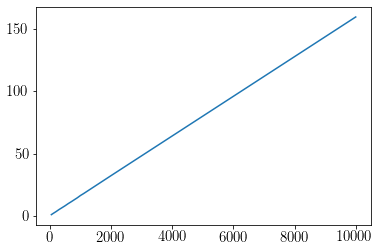

In [169]:
plt.plot(ns, ts)

In [170]:
def est_time(n):
    a, b = np.polyfit(ns, ts, 1)
    return a*n + b

In [171]:
est_time(401*401) / 60 / 60

0.7146016474845978

### Errors

In [130]:
g = np.linspace(-1, 1, 101)
for a in g:
    for b in g:
        mse_error(a, b, 1.05)

ValueError: operands could not be broadcast together with shapes (4,) (100000,) 

# Basic Run

In [49]:
avgs = np.load('models/univariate/simple/ab_mse/set_0/avgs.npy')
ps = np.round(np.linspace(-2, 2, 101), 2)

In [ ]:
ps[(ps >= 1) & (ps <= 1.5)]

In [ ]:
avgs[(ps >= 1) & (ps <= 1.5)]

# Empirical

In [ ]:
p = -1
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 0.5
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 1
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 1.24
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 1.48
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 2
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 10
aa, bb = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = mse_p(aa, bb, p)

fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$p = {}$'.format(p))
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

# Numerical (MSE)

Changing the value by 0.01 has what affect on the likelihood ratio?

In [ ]:
dirstr = 'anims/mses/'

In [ ]:
aa, bb = np.meshgrid(np.linspace(-1, 1, 2001), np.linspace(-1, 1, 2001))

np.save(dirstr + 'aa.npy', aa)
np.save(dirstr + 'bb.npy', bb)

In [ ]:
p = 1.05
zz = nmse_p(aa, bb, p)
np.save(dirstr + 'zz_{}.npy'.format(p), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 1.25
zz = nmse_p(aa, bb, p)
np.save(dirstr + 'zz_{}.npy'.format(p), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 2
zz = nmse_p(aa, bb, p)
np.save(dirstr + 'zz_{}.npy'.format(p), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

In [ ]:
p = 6
zz = nmse_p(aa, bb, p)
np.save(dirstr + 'zz_{}.npy'.format(p), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

# Numerical (SQR)

In [107]:
dirstr = 'anims/sqrs/'

In [108]:
aa, bb = np.meshgrid(np.linspace(-1, 1, 2001), np.linspace(-1, 1, 2001))

np.save(dirstr + 'aa.npy', aa)
np.save(dirstr + 'bb.npy', bb)

In [109]:
r = 0.005
zz = nexp_sqr_r(aa, bb, r)
np.save(dirstr + 'zz_{}.npy'.format(r), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

[1.] [0.]


In [110]:
r = 0.02
zz = nexp_sqr_r(aa, bb, r)
np.save(dirstr + 'zz_{}.npy'.format(r), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

[1.] [0.]


In [111]:
r = 1
zz = nexp_sqr_r(aa, bb, r)
np.save(dirstr + 'zz_{}.npy'.format(r), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

[0.2] [0.]


In [112]:
r = 5
zz = nexp_sqr_r(aa, bb, r)
np.save(dirstr + 'zz_{}.npy'.format(r), zz)
print(aa[zz == np.min(zz)], bb[zz == np.min(zz)])

[0.04] [0.]


# Plotting (MSE)

In [ ]:
dirstr = 'anims/mses/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

In [ ]:
p = 1.05

zz = np.load(dirstr + 'zz_{}.npy'.format(p))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$p = {}$'.format(p), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_mse_1.05.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
p = 1.25

zz = np.load(dirstr + 'zz_{}.npy'.format(p))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$p = {}$'.format(p), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_mse_1.25.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
p = 2

zz = np.load(dirstr + 'zz_{}.npy'.format(p))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$p = {}$'.format(p), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_mse_2.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
p = 6

zz = np.load(dirstr + 'zz_{}.npy'.format(p))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$p = {}$'.format(p), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_mse_6.png', 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
lr = make_lr(bkgd, sgnl)

In [ ]:
def make_c(a):
    return lambda x: sig(a*x)

def make_lr(c, p):
    return lambda x: (c(x) / (1 - c(x)))**(p - 1)
                      
c_1 = make_c(4)
c_2 = make_c(0.8)
c_3 = make_c(0.2)
c_4 = make_c(0.04)

lr_1 = make_lr(c_1, 1.05)
lr_2 = make_lr(c_2, 1.25)
lr_3 = make_lr(c_3, 2)
lr_4 = make_lr(c_4, 6)

In [ ]:
mae(lr_1), mae(lr_2), mae(lr_3), mae(lr_4)

In [ ]:
d = 0.01

In [ ]:
c_11 = make_c(4 + d)
c_12 = make_c(4 - d)

c_21 = make_c(0.8 + d)
c_22 = make_c(0.8 - d)

c_31 = make_c(0.2 + d)
c_32 = make_c(0.2 - d)

c_41 = make_c(0.04 + d)
c_42 = make_c(0.04 - d)

lr_11 = make_lr(c_11, 1.05)
lr_12 = make_lr(c_12, 1.05)

lr_21 = make_lr(c_21, 1.25)
lr_22 = make_lr(c_22, 1.25)

lr_31 = make_lr(c_31, 2)
lr_32 = make_lr(c_32, 2)

lr_41 = make_lr(c_41, 6)
lr_42 = make_lr(c_42, 6)

In [ ]:
mae(lr_11), mae(lr_1), mae(lr_12)

In [ ]:
mae(lr_21), mae(lr_2), mae(lr_22)

In [ ]:
mae(lr_31), mae(c_3), mae(lr_32)

In [ ]:
mae(lr_41), mae(lr_4), mae(lr_42)

In [ ]:
xs = np.linspace(-6, 6, 1000)
plt.plot(xs, lr(xs), c = 'k', label = 'Exact')
plt.plot(xs, lr_1(xs))

## Running

In [ ]:
print('BCE')
bces, aa, bb = gridded(bce,-3, 3, 0.01, 15)
print('\nMSE')
mses, _, _ = gridded(mse, -3, 3, 0.01, 15)
print('\nMLC')
mlcs, _, _ = gridded(mlc, -3, 3, 0.01, 15)
print('\nSQR')
sqrs, _, _ = gridded(sqr, -3, 3, 0.01, 15)

In [ ]:
np.save('anims/bces', bces)
np.save('anims/mses', mses)
np.save('anims/mlcs', mlcs)
np.save('anims/sqrs', sqrs)
np.save('anims/aa', aa)
np.save('anims/bb', bb)

## Examining

In [ ]:
aa = np.load('anims/aa.npy')
bb = np.load('anims/bb.npy')

bces = np.load('anims/bces.npy')
mses = np.load('anims/mses.npy')
mlcs = np.load('anims/mlcs.npy')
sqrs = np.load('anims/sqrs.npy')

nbces = np.load('anims/nbces.npy')
nmses = np.load('anims/nmses.npy')
nmlcs = np.load('anims/nmlcs.npy')
nsqrs = np.load('anims/nsqrs.npy')

In [ ]:
print('Empirical Estimation')
print(aa[bces == np.min(bces)], bb[bces == np.min(bces)])
#print(aa[mses == np.min(mses)], bb[mses == np.min(mses)])
#print(aa[mlcs == np.min(mlcs)], bb[mlcs == np.min(mlcs)])
#print(aa[sqrs == np.min(sqrs)], bb[sqrs == np.min(sqrs)])
print()
print('Numerical Estimation')
print(aa[nbces == np.min(nbces)], bb[nbces == np.min(nbces)])
print(aa[nmses == np.min(nmses)], bb[nmses == np.min(nmses)])
print(aa[nmlcs == np.min(nmlcs)], bb[nmlcs == np.min(nmlcs)])
print(aa[nsqrs == np.min(nsqrs)], bb[nsqrs == np.min(nsqrs)])

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(aa, bb, bces, s = 5, c = bces, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')


# Plotting (SQR)

In [113]:
dirstr = 'anims/sqrs/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

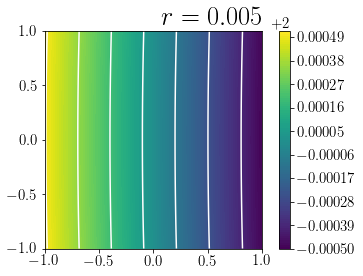

In [114]:
r = 0.005

zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_sqr_0.005.png', 
            dpi=300, 
            bbox_inches='tight')

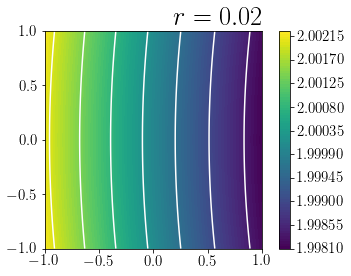

In [115]:
r = 0.02

zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_sqr_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

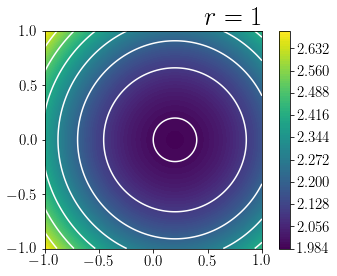

In [116]:
r = 1

zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_sqr_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

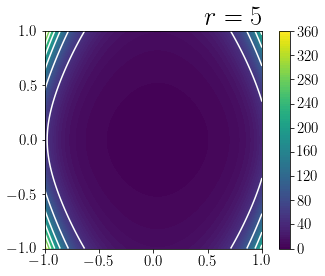

In [117]:
r = 5

zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 100)
plt.colorbar()
plt.contour(aa, bb, zz, colors = 'white')
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_aspect('equal')
plt.savefig('plots/paper/ab_sqr_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

# Plot All

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

In [ ]:
nbce_zs = np.load('anims/nbce_zs.npy')
nmse_zs = np.load('anims/nmse_zs.npy')
nmlc_zs = np.load('anims/nmlc_zs.npy')
nsqr_zs = np.load('anims/nsqr_zs.npy')

In [ ]:
x_min = g[nbce_zs == min(nbce_zs)][:, 0]
y_min = g[nbce_zs == min(nbce_zs)][:, 1]
z_min = nbce_zs[nbce_zs == min(nbce_zs)]

In [ ]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, nbce_zs, s = 5, c = nbce_zs, cmap = 'viridis')
ax.scatter(
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = nbce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, nmse_zs, s = 5, c = nmse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = nmse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, nmlc_zs, s = 5, c = nmlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = nmlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, nsqr_zs, s = 5, c = nsqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = nsqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

# Rotating Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'BCE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)  
ani.save('anims/bce_2.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MSE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mse.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mlc.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/sqr.gif')

# Static Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

#plt.savefig('plots/scratch/bce_landscape_100.png',
#            dpi=1200, 
#            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = bce_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/bce_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mse_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mlc_zs, c = mlc_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mlc_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, sqr_zs, c = sqr_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = sqr_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

# Shifting Gaussians

## BCE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [bce(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.savefig('anims/shift/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    i += 1

## MSE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mse(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 1)
    plt.savefig('anims/shift/mse/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## MLC

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mlc(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 38)
    plt.savefig('anims/shift/mlc/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [sqr(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/shift/sqr/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $A/B$ Parametrizations

## MSE

In [ ]:
p = 1.25
aa, bb = np.meshgrid(np.linspace(-4, 4, 601), np.linspace(-4, 4, 601))

zz = nmse_p(aa, bb, p)

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

In [ ]:
p = 10
aa, bb = np.meshgrid(np.linspace(-4, 4, 601), np.linspace(-4, 4, 601))

zz = nmse_p(aa, bb, p)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

aa[zz == np.min(zz)], bb[zz == np.min(zz)]

In [ ]:
p = 0.5
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

zz = nmse_p(aa, bb, p)

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

In [ ]:
p = 0.9
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

zz = nmse_p(aa, bb, p)

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

In [ ]:
p = 1
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

zz = nmse_p(aa, bb, p)

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

In [ ]:
p = 1.1
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

zz = nmse_p(aa, bb, p)

In [ ]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(aa, bb, zz, s = 5, c = zz, cmap = 'viridis')

In [ ]:
aa[zz == np.min(zz)], bb[zz == np.min(zz)]

In [ ]:
ps = np.arange(-2, 2, 0.05)
ps[61]

In [ ]:
ps = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for p in ps:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [mse_p(pt[0], pt[1], p)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 5)
    plt.savefig('anims/mse_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
r = 10
aa, bb = np.meshgrid(np.linspace(-3, 3, 601), np.linspace(-3, 3, 601))

zz = nexpsqr_r(aa, bb, r)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
idx = ~np.isnan(zz)
ax.scatter(aa[idx], bb[idx], zz[idx], c = zz[idx], s = 5, cmap = 'viridis')

In [ ]:
rs = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for r in rs:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [sqr_r(pt[0], pt[1], r)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/sqr_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $C$ Parametrizations

## MLC

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_mlc_zs, s = 5, c = exp_mlc_zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_mlc_2.gif')

## SQR

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_sqr_zs, s = 5, c = exp_sqr_zs, cmap = 'viridis')
    ax.set_zlim(1.5, 6)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_sqr_2.gif')

# Gamma Landscapes

In [ ]:
N = 5 * 10**3
bkgd = stats.gamma.rvs(5, 1, size = N)
sgnl = stats.gamma.rvs(6, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Betas

In [ ]:
N = 5 * 10**3
bkgd = stats.beta.rvs(2, 3, size = N)
sgnl = stats.beta.rvs(3, 2, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

g = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Scratch

In [ ]:
import numpy as np
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt

In [ ]:
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)
#eps = np.finfo(float).eps
eps = 1e-7

In [ ]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [ ]:
# Numerical estimation of losses

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

@np.vectorize
def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad(g, -np.inf, np.inf)[0]

@np.vectorize
def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad(g, -np.inf, np.inf)[0]

def vbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

def vsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad_vec(g, -np.inf, np.inf)[0]

In [ ]:
aa, bb = np.meshgrid(np.linspace(-1.5, 1.5, 21), np.linspace(-1.5, 1.5, 21))

In [ ]:
vvc = vbce(aa, bb)
vvs = vmse(aa, bb)
vvl = vmlc(aa, bb)
vvq = vsqr(aa, bb)

In [ ]:
nnc = nbce(aa, bb)
nns = nmse(aa, bb)
nnl = nmlc(aa, bb)
nnq = nsqr(aa, bb)

In [ ]:
np.max(vvc - nnc), np.max(vvs - nns), np.max(vvl - nnl), np.max(vvq - nnq)

# The Issue


In [ ]:
eps = np.finfo(float).eps

In [ ]:
fa = 0.19
fb = 1.02
f = lambda x: -(sgnl.pdf(x) * -1 / (relu(fa*x + fb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(fa*x + fb)**0.5 )

In [ ]:
ha = 0.15
hb = 1.02
h = lambda x: -(sgnl.pdf(x) * -1 / (relu(ha*x + hb) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(ha*x + hb)**0.5 )

In [ ]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

In [ ]:
-hb / ha

In [ ]:
-fb / fa

In [ ]:
x = xs[f(xs) == np.max(f(xs))]

In [ ]:
x

In [ ]:
sgnl.pdf(x)

In [ ]:
1 / (relu(ha*x + hb) + eps)**0.5

In [ ]:
1 / (relu(fa*x + fb) + eps)**0.5

In [ ]:
eps = 1e-11

In [ ]:
xs = np.linspace(-7, 7, 1000)
plt.plot(xs, f(xs), label = 'f')
plt.plot(xs, h(xs), label = 'h')
plt.legend();

# Vectorization

## Method 1: Numpy Vectorization

A one-dimensional example.

In [ ]:
fun2int = lambda x, a: np.sqrt(x+a)
intfun = lambda a: integrate.quad(fun2int, 0, 4, args=(a))[0]
vec_int = np.vectorize(intfun)
vec_int(np.linspace(0,2,5))

While this doesn't speed up performance, it is convenient. It also allows for interval modifying based on the input.

In [ ]:
j = lambda x, a, b: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                      bkgd.pdf(x) * -relu(a*x + b)**0.5 )
t = lambda a, b: integrate.quad(j, a == 0 and -np.inf or -b/a, np.inf, args=(a, b))[0]
vec_t = np.vectorize(t)

In [ ]:
vec_t([-1, 0, 1], [0, 1, 2])

In [ ]:
vec_t([-1, 0, 1], 0)

In [ ]:
vec_t([-1, 0, 1], 1)

In [ ]:
vec_t([-1, 0, 1], 2)

In [ ]:
vec_t([[-1, 0, 1], [-1, 0, 1]], [[-1, -1, -1], [0, 0, 0]])

In [ ]:
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 11), np.linspace(-1.5, 1.5, 11))
#g = np.round(np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1), 3)

In [ ]:
plt.contour(X, Y, vec_t(X, Y))

## Method 2: quad_vec

This results in a speed-up, but it doesn't allow us to modify the interval based on the values of $a$ and $b$. We would have to tune epsilon instead.

In [ ]:
np.array([[a, b] for a in [-1, 0, 1] for b in [-1, 0, 1]]).reshape(-1)

In [ ]:
aa = [-1, 0, 1]
bb = [-1, 0, 1]
f = lambda x: np.array([bkgd.pdf(x) * -relu(a*x + b)**0.5 for a in aa for b in bb])

In [ ]:
integrate.quad_vec(f, -np.inf, np.inf)

In [ ]:
a, b = np.meshgrid([-1, 0, 1], [-1, 0, 1])
f = lambda x: 1 / (1 + np.exp(a*x**2 + b))

In [ ]:
f(1)

In [ ]:
integrate.quad_vec(f, -np.inf, np.inf)

In [ ]:
(bkgd.pdf(1) + relu(a*1 + b)).reshape(-1).reshape(a.shape)

In [ ]:
a, b = np.meshgrid([-1, 0.19, 1], [-1, 1.02, 1])
g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                bkgd.pdf(x) * -relu(a*x + b)**0.5 )

In [ ]:
g(0)

This appears to vectorize properly, but since we can't have special integral bounds, suffers from that issue instead.

In [ ]:
eps = np.finfo(float).eps

In [ ]:
integrate.quad_vec(g, -np.inf, np.inf)

In [ ]:
np.minimum(-b/a, -np.inf).reshape(-1)